## Time Series - Trend & Seasonality

Let's look at some data with some seasonal trends. The dataset we will use contains total monthly passenger traffic at Schiphol airport between 1999 and 2019 from [Statistics Netherlands (CBS)](https://opendata.cbs.nl/statline/#/CBS/en/dataset/37478ENG/table?dl=6F18). Each datapoint indicates the total number of passengers traveled via Schiphol in millions in each particular month.

- [Visualising data and identifying trends](#trends)
- [Separating trends, seasonal trends and residuals with Decomposition](#ets)
- [Dealing with Seasonality](#seasonality)
- [Feature engineering](#features)

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pylab as plt
from matplotlib import dates

from sklearn.linear_model import LinearRegression


%matplotlib inline 

In [2]:
# read in data & divide by 1,000,000
schiphol = pd.read_csv('data/schiphol_passengers.csv', index_col='date', parse_dates=True) / 1_000_000
schiphol.index.freq = 'MS' #indicating that the time series has monthly frequency
schiphol.head()

,total_passengers
date,
1999-01-01,2.372578
1999-02-01,2.332664
1999-03-01,2.825328
1999-04-01,2.901478
1999-05-01,3.263955


<a id='trends'></a>
## Visualising and identifying trends

Firstly, let's visualise the data.

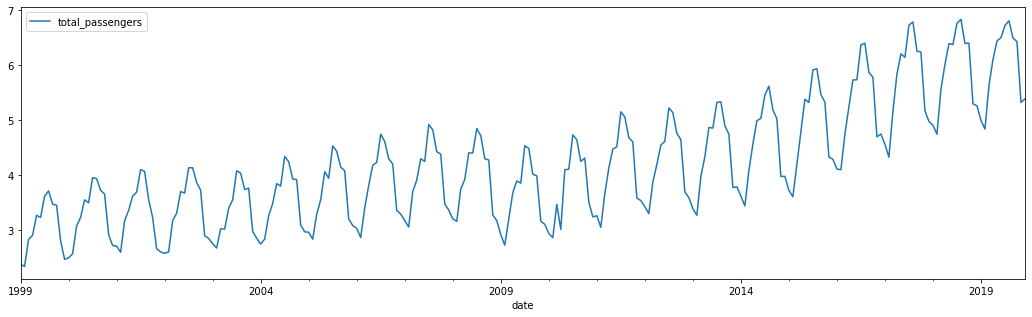

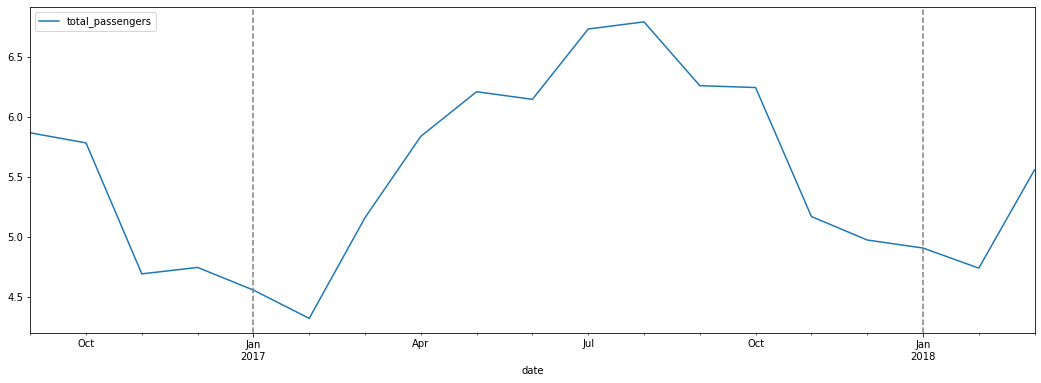

In [3]:
# Plot all data
ax = schiphol.plot(figsize=(18,5))

# Plot over one year - 2017
ax = schiphol['2016-09-01':'2018-03-01'].plot(figsize=(18,6))
ax.axvline('2017', color='grey', linestyle='--')
ax.axvline('2018', color='grey', linestyle='--')

When visualising time series data it is good to look out for:

- **Trends**: Upward / horizontal / downward
- **Seasonality**: Predictably repeating cycles - weekly/monthly/yearly etc
- **Cyclic components**: Patterns with set repetition outside of seasonality
- **Irregular components**: Patterns with no set repetition - for example trend breaks or random shocks
- **Residuals**: The remaining part of the series that cannot be further explicitly modeled

Is there a way to separate these?

<a id='ets'></a>
## Error-Trend-Seasonality Decomposition

We may want to separate the time series into the **trend**, the **seasonality** and the **error component** (ETS). ETS decomposition can be achieved by creating a generalized model that fits our data.

`seasonal_decompose` from  `statsmodels` library can quickly provide a simple ETS decomposition:

$$Y_t = T_t + S_t + e_t$$

Each datapoint is split into a trend $Y_t$, seasonal $S_t$ and residual $e_t$ components. If the trend appears to be non-linear, `model='multiplicative'` option can be used, which implies the above decomposition with the terms multiplied rather than added up.

Building such decompositions helps to inspect and analyze the general behavior of a time series. Note that we are not yet concerned with forecasting - our focus for now is understanding the current data.

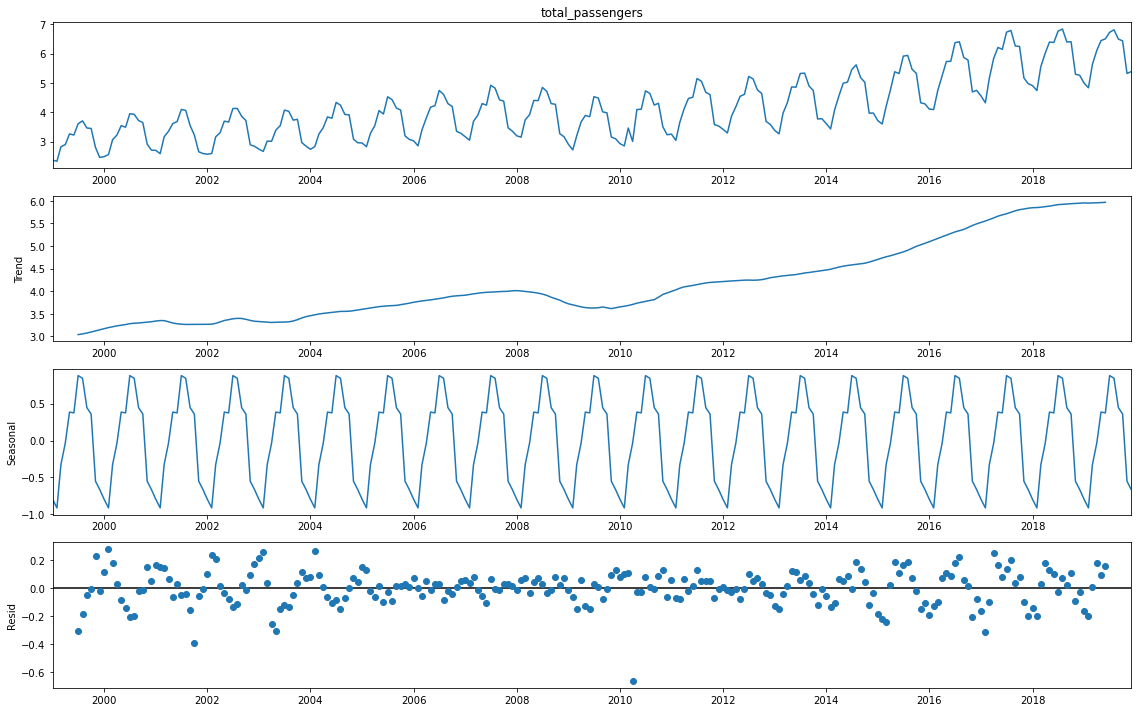

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

Decomposition = seasonal_decompose(schiphol['total_passengers'], model = 'additive')  

with plt.rc_context():
    plt.rc("figure", figsize=(16,10))
    Decomposition.plot();

We can directly access the separated data points for trend `Decomposition.trend`, seasonality `Decomposition.seasonal` and residuals `Decomposition.resid`

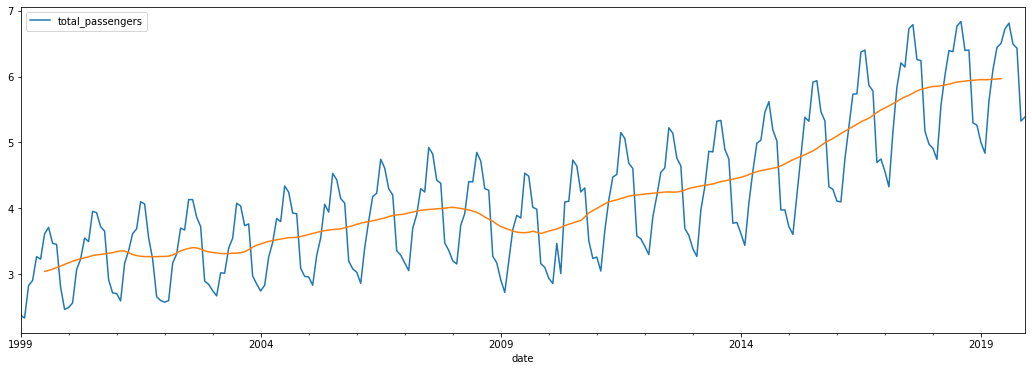

In [5]:
fig, ax = plt.subplots(figsize=(18,6))
schiphol.plot(ax = ax)
Decomposition.trend.plot(ax = ax);

Another quick way to detect any recurrent patterns in the data is by using the *autocorrelation plot*. **Autocorrelation** allows us to look at the correlation between the current data and a lag of the data where lag can be defined. Often data to be correlated strongly when lag=1.

Values close to -1 or 1 are considered to be strong correlated (negatively or positively). 

Used a lot in predicting stock prices, `.autocorr()` can tell us whether a stock price has momentum (positive correlation) or is mean reversing (negative correlation):

0.9249173904881823


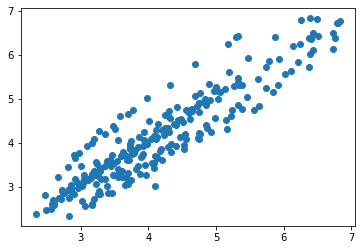

In [6]:
# Look at the correlation with different lags
lag = 1

print(schiphol['total_passengers'].autocorr(lag))

scat = (
    schiphol
    .assign(shift = schiphol['total_passengers'].shift(lag))
)

plt.scatter(scat['total_passengers'], scat['shift'])
plt.show()

We don't need to just look at the autocorrelation for individual lags, let's use the `.plot_acf()` function from statsmodels to see for multiple lags side-by-side. Here we can see cyclical patterns in the autocorrelation plot which are likely signs of seasonal fluctuations.

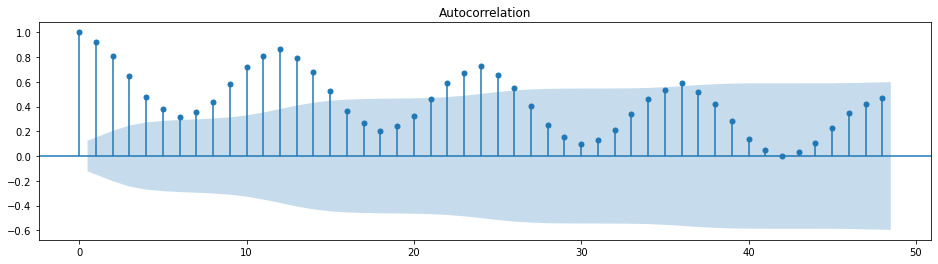

In [7]:
from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots(figsize = (16,4))
plot_acf(schiphol['total_passengers'], lags = 48, ax = ax);

<a id='ex-corr'></a>
## <mark>Exercise - guess the Autocorrelation</mark>

Can you correctly match the **graphs A, B, C, D** and **graphs 1, 2, 3, 4** to:

- Hourly household powerconsumption
- The daily processing of raw cow's milk into cheese products by dairy factories in the Netherlands
- Hourly power consumption of a single household in Paris
- Monthly Google trends for the word 'diet'

Simply plotting the data:
<img src='images/eg-plots.png'>

Plotting the autocorrelation:
<img src='images/eg-acf.png'>

If you want to play with the data (it's anonymised!) then head over to [this notebook](Exercise.ipynb) 

<a id='seasonality'></a>
## Dealing with Seasonality
Seasonality obscures the actual signal, which complicates both understanding of the underlying processes and further forecasting. Understanding it gets us closer to what actually happens in the data ― which also means easier forecasting.

One of the simplest ways to identify the main pattern(s) taking place in the data is to fit a linear regression. We can learn about the general trend, (mostly) leaving the seasonality aside. We can evaluate the fit using the $R^2$ score - the closer to 1, the better the model captures the patterns in the data. Note though that this does not yet necessarily mean better forecasting.

In [65]:
# create dummy period variable X
X = schiphol.assign(period_num=np.arange(len(schiphol.index))).drop('total_passengers', axis=1)
y = schiphol['total_passengers'].values

In [60]:
lm = LinearRegression()
lm.fit(X, y)
print(f"R^2 is {round(lm.score(X, y),3)}")

R^2 is 0.593


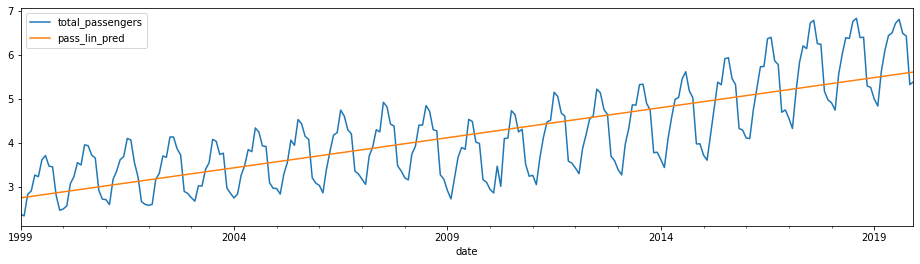

In [61]:
schiphol.assign(pass_lin_pred=lm.predict(X)).plot(figsize=(16,4));

A simple linear regression illustrates the overall passenger traffic growth over time, but (expectably) fails to take the 2009 drop into account. One way to correct this would be to introduce a dummy term for the data points after 2009:

In [12]:
schiphol['after2009'] = [1 if el>pd.Timestamp('2009') else 0 for el in schiphol.index]

X_break = (
    schiphol[['period_num','after2009']]
    .assign(interaction = lambda df: df.period_num*df.after2009)
)

lm_break = LinearRegression().fit(X_break, y)
print(f"R^2 is {round(lm_break.score(X_break, y),3)}")

schiphol['pass_lin_b_pred'] = lm_break.predict(X_break)

R^2 is 0.664


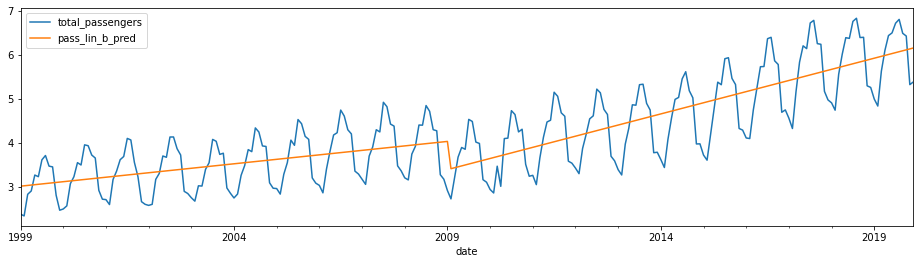

In [13]:
schiphol[['total_passengers','pass_lin_b_pred']].plot(figsize=(16,4));

This seems to be a much better fit. It also illustrates that even though passenger traffic dropped during the 2008-2009 Crisis, post-crisis growth appears to be more rapid than before.

<a id='features'></a>
## Feature Engineering

We may want to do more than just identifying the trend though. Modeling the seasonality would allow us to understand and quantify the seasonal effects. And this means an ability to model not just the average behavior, but exact values during each season.

A simple way to achieve this would be to add seasonal dummy terms to the baseline linear regression. In fact, *feature engineering* can be a very powerful tool in Time Series Analysis, allowing us to capture rather complex patterns with a few simple engineered variables added.

In the code below, we use *ColumnTransformer* - a handy tool from scikit-learn to apply some transformation to one column (*'quarter'*) and keep the rest unchanged. 

In [66]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [67]:
#identifying quarters and preprocessing them
schiphol['quarter']=schiphol.index.quarter

X_quarter = X.assign(quarter = schiphol.index.quarter)

feature_transformer = ColumnTransformer(
     [('numeric', 'passthrough', ['period_num']),
      ('categorical', OneHotEncoder(sparse=False, drop='first'), ['quarter'])]
)

We further combine our preprocessing step with the model training using a Machine Learning pipeline from scikit-learn: a powerful way to keep both preprocessing and machine learning together in a single logical unit.

In [68]:
#training the model
model_quarter = Pipeline([
    ('preprocess', feature_transformer),
    ('model', LinearRegression())
])

lm_quarter = model_quarter.fit(X_quarter, y)
print(f"R^2 is {round(lm_quarter.score(X_quarter, y),3)}")

schiphol['pass_lin_q_pred'] = lm_quarter.predict(X_quarter)

R^2 is 0.83


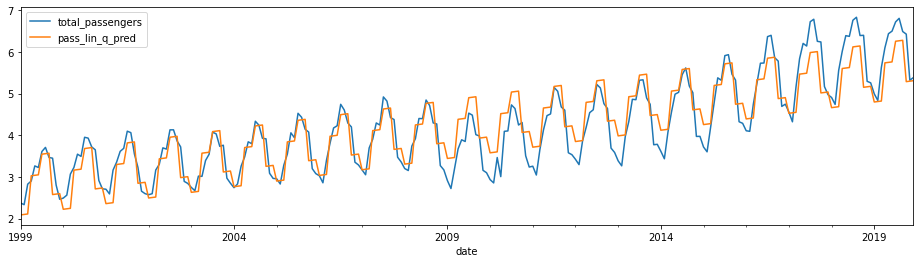

In [69]:
schiphol[['total_passengers','pass_lin_q_pred']].plot(figsize=(16,4));

This simple model appears to reasonably capture the observed seasonality, even if it fails to acknowledge the drop after the 2008-2008 Financial Crisis. Actual seasonality seems more complex than just fixed quarterly jumps or drops, but this approach already illustrates the main patterns. 

Moreover, we can separate seasonality from the trend and the residuals to see what we're missing.

In [18]:
average_season_effect = np.dot(lm_quarter['model'].coef_[1:],(0.25,0.25,0.25))

simple_ets = (
    schiphol
    .loc[:,['total_passengers','pass_lin_q_pred']]
    .rename(columns={"total_passengers": "y_real", "pass_lin_q_pred": "y_hat"})
    .assign(residuals = lambda df: df['y_real']-df['y_hat'],
            trend = lambda df: lm_quarter['model'].intercept_+lm_quarter['model'].coef_[0]*np.arange(len(df))+average_season_effect,
            seasonal = lambda df: df['y_hat'] - df['trend'])
)

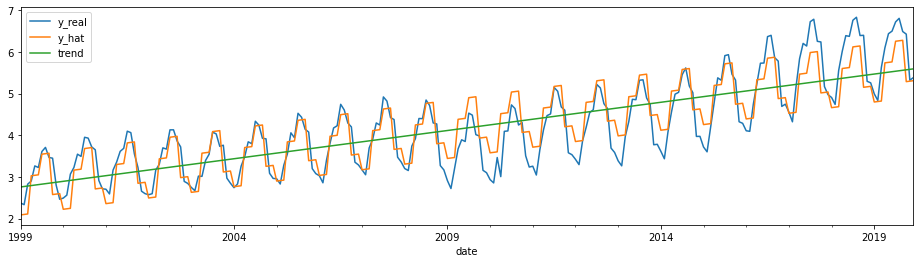

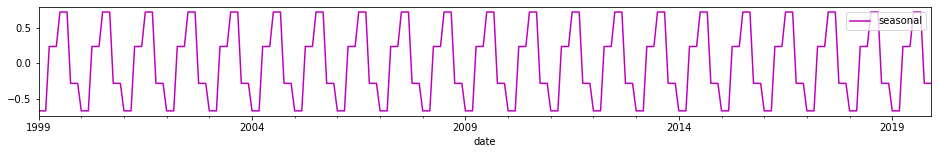

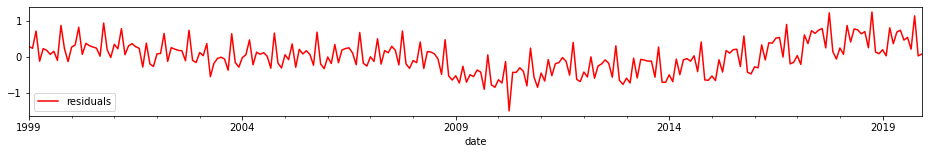

In [19]:
simple_ets[['y_real','y_hat','trend']].plot(figsize=(16,4))
simple_ets[['seasonal']].plot(figsize=(16,2), c='m')
simple_ets[['residuals']].plot(figsize=(16,2), c='r');

In case it is unclear from the residuals plot, we can also inspect the autocorrelation plot for the residuals to see if we have likely missed some important (seasonal) patterns with out model. In this case, based on the remaining autocorrelation in the residuals, our seasonality representation is clearly a bit too simplistic:

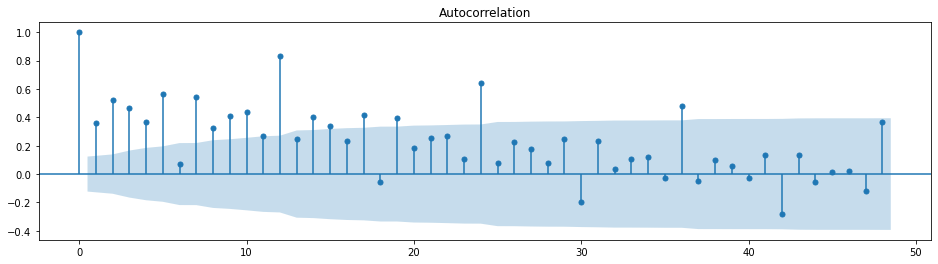

In [20]:
fig, ax = plt.subplots(figsize=(16,4))
plot_acf(simple_ets['residuals'], lags=48, ax=ax);

### Feature Engineering - Monthly Dummies

Instead of the quarterly dummies, let's add monthly dummies as well as post-2009 dummy. We can also add interaction and polinomial terms for all features

Is it a better fit?

R^2 is 0.948


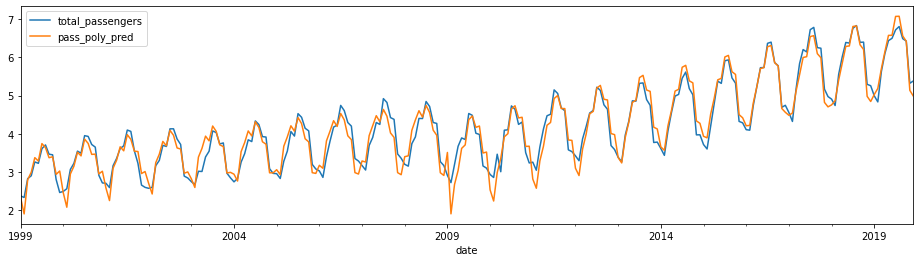

In [22]:
from sklearn.preprocessing import PolynomialFeatures

#identifying months and preprocessing them
schiphol['month'] = schiphol.index.month
X_month = schiphol[['period_num','after2009','month']]

feature_transformer = ColumnTransformer(
     [('categorical', OneHotEncoder(sparse=False, drop='first'), ['month'])],
    remainder='passthrough'
)

#creating the model
model_monthly = Pipeline([
    ('preprocess', feature_transformer),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', LinearRegression())
])

#model fitting, predictions and plotting
lm_poly = model_monthly.fit(X_month, y)
print(f"R^2 is {round(lm_poly.score(X_month, y),3)}")

schiphol['pass_poly_pred'] = lm_poly.predict(X_month)

schiphol[['total_passengers','pass_poly_pred']].plot(figsize=(16,4));